<a href="https://colab.research.google.com/github/The20thDuck/Neuro-140-Project/blob/main/TransformerGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch as t
import torchvision
from tqdm import tqdm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap

In [2]:
train_data = torchvision.datasets.FashionMNIST("data", train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]), download=True)
train_loader = t.utils.data.DataLoader(train_data, batch_size = 128, shuffle=True, num_workers=2)

In [3]:
!pip install einops
import einops

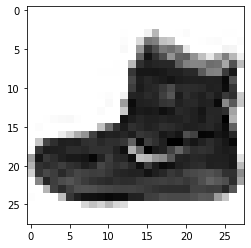

In [4]:
plt.imshow(train_data[0][0].squeeze(), plt.cm.binary)

In [49]:
ngc = 64
latent_size = 100
num_classes = 10

class Generator(t.nn.Module):
  def __init__(self, 
               latent_size=latent_size, 
               num_classes = num_classes, 
               emb_size = 96, 
               nhead=4,
               L1 = 4,
               L2 = 4,
               img_size = 28,
               in_channels=1):
    super().__init__()
    self.emb_size = emb_size
    self.img_size = img_size
    # self.latent_size = latent_size
    self.linear1 = t.nn.Linear(latent_size, emb_size*(img_size//4)**2)
    self.block1 = t.nn.Sequential(
        *[t.nn.TransformerEncoderLayer(
        emb_size,
        nhead=nhead, 
        dim_feedforward=emb_size*4, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L1)]
    )
    self.pixel1 = t.nn.PixelShuffle(2)
    self.block2 = t.nn.Sequential(
        *[t.nn.TransformerEncoderLayer(
        emb_size//4,
        nhead=nhead, 
        dim_feedforward=emb_size, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L2)]
    )
    self.pixel2 = t.nn.PixelShuffle(2)
    self.project = t.nn.Linear(emb_size//16, in_channels)
    self.tanh = t.nn.Tanh()

  def forward(self, z):
    b = z.shape[0]
    emb = self.linear1(z).view((b, (self.img_size//4)**2, self.emb_size))
    emb = self.block1(emb)
    emb_to_pixel = "b (h w) c -> b c h w"
    pixel_to_emb = "b c h w -> b (h w) c"

    pixels = einops.rearrange(emb, emb_to_pixel, h = self.img_size//4)
    pixels = self.pixel1(pixels)
    emb = einops.rearrange(pixels, pixel_to_emb, h = self.img_size//2)
    emb = self.block2(emb)
    pixels = einops.rearrange(emb, emb_to_pixel, h = self.img_size//2)
    pixels = self.pixel2(pixels)
    emb = einops.rearrange(pixels, pixel_to_emb, h = self.img_size)
    emb = self.project(emb)
    pixels = einops.rearrange(emb, emb_to_pixel, h = self.img_size)
    return self.tanh(pixels)

# class Generator(t.nn.Module):
#   def __init__(self, latent_size=latent_size, num_classes = num_classes):
#     super().__init__()
#     self.layers = t.nn.Sequential(
#         t.nn.ConvTranspose2d(latent_size, ngc*4, 4, 1, 0),
#         t.nn.BatchNorm2d(ngc*4),
#         t.nn.ReLU(),
#         t.nn.ConvTranspose2d(ngc*4, ngc*2, 4, 2, 1),
#         t.nn.BatchNorm2d(ngc*2),
#         t.nn.ReLU(),
#         t.nn.ConvTranspose2d(ngc*2, ngc*1, 4, 2, 1),
#         t.nn.BatchNorm2d(ngc),
#         t.nn.ReLU(),
#         t.nn.ConvTranspose2d(ngc*1, 1, 4, 2, 3),
#         t.nn.Tanh()
#     )
#   def forward(self, z):
#     return self.layers(z.view(-1, latent_size, 1, 1))

class PatchEmbedding(t.nn.Module):
  def __init__(self, in_channels, patch_size, emb_size, imgsize):
    super().__init__()
    self.cls_token = t.nn.Parameter(t.randn(1, 1, emb_size)) # b, n, emb_size. Add to the list of module params
    self.n = (imgsize//patch_size)**2
    self.emb_size = emb_size
    self.position_embeddings = t.nn.Parameter(t.randn(1, self.n + 1, emb_size)) # +1 for cls
    self.projection = t.nn.Conv2d(in_channels, emb_size, patch_size, patch_size, 0)

  def forward(self, inputs):
    token_embeddings = einops.rearrange(self.projection(inputs), 'b c h w -> b (h w) c')
    b = inputs.shape[0]
    cls_embeddings = self.cls_token.repeat((b, 1, 1))
    # print(cls_embeddings.shape, token_embeddings.shape, self.position_embeddings.shape)
    return t.cat((cls_embeddings, token_embeddings), dim = 1) + self.position_embeddings

class ClassificationHead(t.nn.Module):
  def __init__(self, num_classes, emb_size):
    super().__init__()
    self.ln = t.nn.LayerNorm((emb_size,), eps = 1e-12)
    self.layer = t.nn.Linear(emb_size, num_classes)

  def forward(self, x):
    return self.layer(self.ln(x)[:,0,:])


class ViT_New(t.nn.Module):
  def __init__(self, in_channels: int = 1, patch_size: int = 4, emb_size: int = 96, nhead=6, imgsize=28, num_classes=1, L = 6, from_hugging = False):
    super().__init__()
    self.patch_emb = PatchEmbedding(in_channels, patch_size, emb_size, imgsize)
    # self.from_hugging = from_hugging
    # if from_hugging:
    #   config = ViTConfig(hidden_size=emb_size, num_hidden_layers = L, num_attention_heads = nhead, intermediate_size=emb_size*4, patch_size=patch_size, image_size=imgsize, encoder_stride=patch_size)
    #   self.encoder = ViTForImageClassification(config).vit.encoder
    # else:
    self.encoder = t.nn.Sequential(*[
      t.nn.TransformerEncoderLayer(
        emb_size,
        nhead=nhead, 
        dim_feedforward=emb_size*4, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L)])
    self.classifier = ClassificationHead(num_classes, emb_size=emb_size)

  def forward(self, x):
    emb = self.patch_emb(x)
    encoding = self.encoder(emb)
    return t.sigmoid(self.classifier(encoding)).flatten()
    



In [50]:
lr = 0.0002
beta1 = 0.
gen = Generator().cuda()
disc = ViT_New().cuda()
optim_g = t.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = t.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))


In [53]:
gz = gen(t.randn(1, 100).cuda())
print(gz.shape)
disc(gz)

torch.Size([1, 1, 28, 28])


tensor([0.4249], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [46]:
criterion = t.nn.BCELoss()

In [54]:
# training loop
num_epochs = 5
real_label = 1.
fake_label = 0.

d_losses = []
g_losses = []
for epoch in range(num_epochs):
  for step, (x, y) in enumerate(tqdm(train_loader)):
    # lab = t.nn.functional.one_hot(y.cuda(), num_classes = num_classes).float()
    # update G
    gen.zero_grad()
    disc.zero_grad()
    b = x.shape[0]
    with t.no_grad():
      z = t.randn(b, latent_size).cuda()
    gz = gen(z)
    dgz = disc(gz)
    # print(dgz.shape, b)
    g_loss = criterion(dgz, t.full((b,), real_label).cuda())
    g_losses.append(g_loss.item())
    g_loss.backward()
    optim_g.step()
    # update D
    disc.zero_grad()
    dx = disc(x.cuda())
    dgz = disc(gz.detach())
    d_loss = criterion(dgz, t.full((b,), fake_label).cuda()) + criterion(dx, t.full((b,), real_label).cuda())
    d_losses.append(d_loss.item())
    d_loss.backward()
    optim_d.step()
    n_steps = 20
    if step % n_steps == 0:
      L_g = t.tensor(g_losses[-n_steps:]).mean()
      L_d = t.tensor(d_losses[-n_steps:]).mean()
      print(f'L_g: {L_g:.4f}, L_d: {L_d:.4f}, dx: {dx.detach().mean().item():.4f}, dgz: {dgz.detach().mean().item():.4f}')
  



  0%|          | 1/469 [00:00<05:24,  1.44it/s]

L_g: 0.8637, L_d: 1.3418, dx: 0.4523, dgz: 0.4216


  4%|▍         | 21/469 [00:08<03:10,  2.35it/s]

L_g: 0.8218, L_d: 1.2620, dx: 0.5936, dgz: 0.2466


  9%|▊         | 41/469 [00:17<03:02,  2.34it/s]

L_g: 1.8632, L_d: 0.5598, dx: 0.9780, dgz: 0.0868


 13%|█▎        | 61/469 [00:25<02:54,  2.34it/s]

L_g: 4.3919, L_d: 0.0307, dx: 0.9927, dgz: 0.0058


 17%|█▋        | 81/469 [00:33<02:45,  2.35it/s]

L_g: 2.7063, L_d: 0.8932, dx: 0.4468, dgz: 0.3197


 22%|██▏       | 101/469 [00:42<02:36,  2.35it/s]

L_g: 1.3615, L_d: 1.0204, dx: 0.5790, dgz: 0.1019


 26%|██▌       | 121/469 [00:50<02:28,  2.34it/s]

L_g: 1.8667, L_d: 0.8556, dx: 0.7050, dgz: 0.2056


 30%|███       | 141/469 [00:58<02:19,  2.35it/s]

L_g: 1.7711, L_d: 0.8726, dx: 0.4218, dgz: 0.0769


 34%|███▍      | 161/469 [01:07<02:11,  2.35it/s]

L_g: 1.1166, L_d: 1.2000, dx: 0.5561, dgz: 0.3954


 39%|███▊      | 181/469 [01:15<02:02,  2.35it/s]

L_g: 0.8846, L_d: 1.2911, dx: 0.4780, dgz: 0.3478


 43%|████▎     | 201/469 [01:23<01:54,  2.35it/s]

L_g: 0.8288, L_d: 1.3202, dx: 0.4694, dgz: 0.4188


 47%|████▋     | 221/469 [01:31<01:45,  2.34it/s]

L_g: 0.8847, L_d: 1.2695, dx: 0.4297, dgz: 0.2715


 51%|█████▏    | 241/469 [01:40<01:37,  2.35it/s]

L_g: 0.9877, L_d: 1.2246, dx: 0.4263, dgz: 0.2652


 56%|█████▌    | 261/469 [01:48<01:28,  2.34it/s]

L_g: 0.9328, L_d: 1.2120, dx: 0.5652, dgz: 0.3351


 60%|█████▉    | 281/469 [01:56<01:19,  2.35it/s]

L_g: 0.9692, L_d: 1.2564, dx: 0.4806, dgz: 0.3860


 64%|██████▍   | 301/469 [02:05<01:11,  2.35it/s]

L_g: 0.9129, L_d: 1.2350, dx: 0.5805, dgz: 0.4410


 68%|██████▊   | 321/469 [02:13<01:02,  2.35it/s]

L_g: 0.9396, L_d: 1.2422, dx: 0.4435, dgz: 0.2887


 73%|███████▎  | 341/469 [02:21<00:54,  2.34it/s]

L_g: 0.9309, L_d: 1.2766, dx: 0.8250, dgz: 0.8071


 77%|███████▋  | 361/469 [02:29<00:45,  2.35it/s]

L_g: 0.9363, L_d: 1.2619, dx: 0.4419, dgz: 0.3263


 81%|████████  | 381/469 [02:38<00:37,  2.35it/s]

L_g: 0.9206, L_d: 1.2175, dx: 0.5444, dgz: 0.3725


 86%|████████▌ | 401/469 [02:46<00:29,  2.34it/s]

L_g: 0.9442, L_d: 1.2496, dx: 0.5490, dgz: 0.4011


 90%|████████▉ | 421/469 [02:54<00:20,  2.35it/s]

L_g: 0.9917, L_d: 1.2359, dx: 0.5077, dgz: 0.3412


 94%|█████████▍| 441/469 [03:03<00:11,  2.35it/s]

L_g: 0.9740, L_d: 1.1888, dx: 0.7457, dgz: 0.5937


 98%|█████████▊| 461/469 [03:11<00:03,  2.35it/s]

L_g: 1.0136, L_d: 1.1780, dx: 0.6992, dgz: 0.4502


  0%|          | 1/469 [00:00<04:40,  1.67it/s]

L_g: 1.0316, L_d: 1.1810, dx: 0.4441, dgz: 0.2307


  4%|▍         | 21/469 [00:08<03:10,  2.35it/s]

L_g: 1.0488, L_d: 1.1520, dx: 0.4906, dgz: 0.3157


  9%|▊         | 41/469 [00:17<03:02,  2.35it/s]

L_g: 1.0619, L_d: 1.1438, dx: 0.7861, dgz: 0.5731


 13%|█▎        | 61/469 [00:25<02:53,  2.35it/s]

L_g: 1.0566, L_d: 1.1379, dx: 0.8218, dgz: 0.6150


 17%|█▋        | 81/469 [00:33<02:45,  2.35it/s]

L_g: 1.0642, L_d: 1.1213, dx: 0.7290, dgz: 0.4471


 22%|██▏       | 101/469 [00:42<02:36,  2.35it/s]

L_g: 1.0807, L_d: 1.1472, dx: 0.7202, dgz: 0.5005


 26%|██▌       | 121/469 [00:50<02:28,  2.35it/s]

L_g: 1.1326, L_d: 1.1126, dx: 0.4983, dgz: 0.2743


 30%|███       | 141/469 [00:58<02:19,  2.35it/s]

L_g: 1.1262, L_d: 1.0697, dx: 0.7568, dgz: 0.4108


 34%|███▍      | 161/469 [01:06<02:11,  2.35it/s]

L_g: 1.2074, L_d: 1.0703, dx: 0.8189, dgz: 0.5447


 39%|███▊      | 181/469 [01:15<02:02,  2.35it/s]

L_g: 1.2126, L_d: 1.0598, dx: 0.7476, dgz: 0.4190


 43%|████▎     | 201/469 [01:23<01:54,  2.35it/s]

L_g: 1.2325, L_d: 1.0201, dx: 0.7704, dgz: 0.4729


 47%|████▋     | 221/469 [01:31<01:45,  2.35it/s]

L_g: 1.2705, L_d: 1.0440, dx: 0.6673, dgz: 0.4021


 51%|█████▏    | 241/469 [01:39<01:37,  2.35it/s]

L_g: 1.2938, L_d: 1.0051, dx: 0.7655, dgz: 0.4350


 56%|█████▌    | 261/469 [01:48<01:28,  2.34it/s]

L_g: 1.2946, L_d: 1.0174, dx: 0.8053, dgz: 0.5310


 60%|█████▉    | 281/469 [01:56<01:19,  2.35it/s]

L_g: 1.3614, L_d: 0.9580, dx: 0.7908, dgz: 0.3895


 64%|██████▍   | 301/469 [02:04<01:11,  2.35it/s]

L_g: 1.3130, L_d: 0.9972, dx: 0.7650, dgz: 0.3508


 68%|██████▊   | 321/469 [02:13<01:02,  2.35it/s]

L_g: 1.4111, L_d: 0.9470, dx: 0.7574, dgz: 0.4110


 73%|███████▎  | 341/469 [02:21<00:54,  2.35it/s]

L_g: 1.4730, L_d: 0.8963, dx: 0.7658, dgz: 0.3009


 77%|███████▋  | 361/469 [02:29<00:45,  2.35it/s]

L_g: 1.5089, L_d: 0.9396, dx: 0.5738, dgz: 0.1649


 81%|████████  | 381/469 [02:37<00:37,  2.35it/s]

L_g: 1.4188, L_d: 0.9552, dx: 0.7299, dgz: 0.2807


 86%|████████▌ | 401/469 [02:46<00:28,  2.35it/s]

L_g: 1.5365, L_d: 0.8835, dx: 0.7830, dgz: 0.3354


 90%|████████▉ | 421/469 [02:54<00:20,  2.34it/s]

L_g: 1.4811, L_d: 0.9253, dx: 0.7644, dgz: 0.3356


 94%|█████████▍| 441/469 [03:02<00:11,  2.35it/s]

L_g: 1.4944, L_d: 0.9150, dx: 0.8195, dgz: 0.4639


 98%|█████████▊| 461/469 [03:11<00:03,  2.35it/s]

L_g: 1.4829, L_d: 0.8981, dx: 0.8039, dgz: 0.3418


  0%|          | 1/469 [00:00<04:35,  1.70it/s]

L_g: 1.5816, L_d: 0.8383, dx: 0.6794, dgz: 0.2090


  4%|▍         | 21/469 [00:08<03:11,  2.34it/s]

L_g: 1.4943, L_d: 0.9163, dx: 0.7248, dgz: 0.2685


  9%|▊         | 41/469 [00:17<03:02,  2.35it/s]

L_g: 1.5357, L_d: 0.8783, dx: 0.7425, dgz: 0.3962


 13%|█▎        | 61/469 [00:25<02:53,  2.35it/s]

L_g: 1.6158, L_d: 0.8436, dx: 0.4928, dgz: 0.1811


 17%|█▋        | 81/469 [00:33<02:45,  2.34it/s]

L_g: 1.4916, L_d: 0.8999, dx: 0.7350, dgz: 0.2550


 22%|██▏       | 101/469 [00:42<02:36,  2.35it/s]

L_g: 1.5101, L_d: 0.8784, dx: 0.7422, dgz: 0.2693


 26%|██▌       | 121/469 [00:50<02:28,  2.35it/s]

L_g: 1.5771, L_d: 0.8769, dx: 0.7100, dgz: 0.2598


 30%|███       | 141/469 [00:58<02:20,  2.34it/s]

L_g: 1.5877, L_d: 0.8630, dx: 0.8039, dgz: 0.3980


 34%|███▍      | 161/469 [01:06<02:11,  2.35it/s]

L_g: 1.5773, L_d: 0.8333, dx: 0.7195, dgz: 0.2640


 39%|███▊      | 181/469 [01:15<02:02,  2.34it/s]

L_g: 1.5795, L_d: 0.8993, dx: 0.5211, dgz: 0.1550


 43%|████▎     | 201/469 [01:23<01:54,  2.35it/s]

L_g: 1.5918, L_d: 0.8481, dx: 0.4799, dgz: 0.1582


 47%|████▋     | 221/469 [01:31<01:45,  2.34it/s]

L_g: 1.4698, L_d: 0.8976, dx: 0.6789, dgz: 0.2137


 51%|█████▏    | 241/469 [01:40<01:37,  2.35it/s]

L_g: 1.4887, L_d: 0.9270, dx: 0.5026, dgz: 0.1827


 56%|█████▌    | 261/469 [01:48<01:28,  2.35it/s]

L_g: 1.5197, L_d: 0.8596, dx: 0.6421, dgz: 0.2340


 60%|█████▉    | 281/469 [01:56<01:20,  2.35it/s]

L_g: 1.4930, L_d: 0.8839, dx: 0.7677, dgz: 0.3437


 64%|██████▍   | 301/469 [02:04<01:11,  2.34it/s]

L_g: 1.5270, L_d: 0.8871, dx: 0.7598, dgz: 0.3148


 68%|██████▊   | 321/469 [02:13<01:03,  2.35it/s]

L_g: 1.5155, L_d: 0.8746, dx: 0.7437, dgz: 0.3486


 73%|███████▎  | 341/469 [02:21<00:54,  2.34it/s]

L_g: 1.5182, L_d: 0.9095, dx: 0.7937, dgz: 0.4132


 77%|███████▋  | 361/469 [02:29<00:45,  2.35it/s]

L_g: 1.4729, L_d: 0.8415, dx: 0.8040, dgz: 0.3006


 81%|████████  | 381/469 [02:38<00:37,  2.35it/s]

L_g: 1.4833, L_d: 0.9177, dx: 0.7134, dgz: 0.2631


 86%|████████▌ | 401/469 [02:46<00:28,  2.35it/s]

L_g: 1.4800, L_d: 0.8884, dx: 0.7880, dgz: 0.3648


 90%|████████▉ | 421/469 [02:54<00:20,  2.35it/s]

L_g: 1.5142, L_d: 0.8661, dx: 0.6132, dgz: 0.2028


 94%|█████████▍| 441/469 [03:02<00:11,  2.34it/s]

L_g: 1.4870, L_d: 0.8899, dx: 0.7857, dgz: 0.3921


 98%|█████████▊| 461/469 [03:11<00:03,  2.35it/s]

L_g: 1.4732, L_d: 0.8865, dx: 0.8036, dgz: 0.3858


  0%|          | 1/469 [00:00<04:27,  1.75it/s]

L_g: 1.4726, L_d: 0.8791, dx: 0.7781, dgz: 0.3410


  4%|▍         | 21/469 [00:08<03:10,  2.35it/s]

L_g: 1.5204, L_d: 0.8913, dx: 0.8004, dgz: 0.4354


  9%|▊         | 41/469 [00:17<03:02,  2.35it/s]

L_g: 1.4936, L_d: 0.8312, dx: 0.7479, dgz: 0.2746


 13%|█▎        | 61/469 [00:25<02:54,  2.34it/s]

L_g: 1.5657, L_d: 0.8279, dx: 0.6869, dgz: 0.2270


 17%|█▋        | 81/469 [00:33<02:45,  2.35it/s]

L_g: 1.4921, L_d: 0.8865, dx: 0.7953, dgz: 0.3808


 22%|██▏       | 101/469 [00:42<02:37,  2.34it/s]

L_g: 1.4644, L_d: 0.8983, dx: 0.6476, dgz: 0.1972


 26%|██▌       | 121/469 [00:50<02:28,  2.34it/s]

L_g: 1.4659, L_d: 0.8821, dx: 0.6761, dgz: 0.2750


 30%|███       | 141/469 [00:58<02:19,  2.34it/s]

L_g: 1.4836, L_d: 0.8907, dx: 0.4441, dgz: 0.1248


 34%|███▍      | 161/469 [01:06<02:11,  2.35it/s]

L_g: 1.4692, L_d: 0.8560, dx: 0.6937, dgz: 0.2301


 39%|███▊      | 181/469 [01:15<02:02,  2.34it/s]

L_g: 1.4974, L_d: 0.8692, dx: 0.6385, dgz: 0.2227


 43%|████▎     | 201/469 [01:23<01:54,  2.34it/s]

L_g: 1.5140, L_d: 0.8690, dx: 0.5535, dgz: 0.1710


 47%|████▋     | 221/469 [01:31<01:45,  2.35it/s]

L_g: 1.4602, L_d: 0.9196, dx: 0.6467, dgz: 0.2751


 51%|█████▏    | 241/469 [01:40<01:37,  2.34it/s]

L_g: 1.4586, L_d: 0.8594, dx: 0.7109, dgz: 0.2541


 56%|█████▌    | 261/469 [01:48<01:28,  2.35it/s]

L_g: 1.5183, L_d: 0.8455, dx: 0.7294, dgz: 0.2632


 60%|█████▉    | 281/469 [01:56<01:20,  2.35it/s]

L_g: 1.4868, L_d: 0.8681, dx: 0.7987, dgz: 0.3511


 64%|██████▍   | 301/469 [02:04<01:11,  2.35it/s]

L_g: 1.4912, L_d: 0.8767, dx: 0.6667, dgz: 0.2136


 68%|██████▊   | 321/469 [02:13<01:02,  2.35it/s]

L_g: 1.4781, L_d: 0.8754, dx: 0.6796, dgz: 0.2716


 73%|███████▎  | 341/469 [02:21<00:54,  2.35it/s]

L_g: 1.4776, L_d: 0.8684, dx: 0.5982, dgz: 0.1732


 77%|███████▋  | 361/469 [02:29<00:45,  2.35it/s]

L_g: 1.4571, L_d: 0.8739, dx: 0.6989, dgz: 0.2749


 81%|████████  | 381/469 [02:38<00:37,  2.35it/s]

L_g: 1.4878, L_d: 0.8691, dx: 0.7246, dgz: 0.2980


 86%|████████▌ | 401/469 [02:46<00:29,  2.34it/s]

L_g: 1.5511, L_d: 0.8481, dx: 0.6526, dgz: 0.2074


 90%|████████▉ | 421/469 [02:54<00:20,  2.35it/s]

L_g: 1.4777, L_d: 0.8646, dx: 0.6643, dgz: 0.2555


 94%|█████████▍| 441/469 [03:02<00:11,  2.35it/s]

L_g: 1.5392, L_d: 0.8338, dx: 0.7554, dgz: 0.2309


 98%|█████████▊| 461/469 [03:11<00:03,  2.35it/s]

L_g: 1.5257, L_d: 0.8595, dx: 0.6710, dgz: 0.2579


  0%|          | 1/469 [00:00<04:32,  1.72it/s]

L_g: 1.4991, L_d: 0.8461, dx: 0.7767, dgz: 0.3281


  4%|▍         | 21/469 [00:08<03:10,  2.35it/s]

L_g: 1.4935, L_d: 0.8786, dx: 0.7363, dgz: 0.2845


  9%|▊         | 41/469 [00:17<03:02,  2.34it/s]

L_g: 1.5282, L_d: 0.8738, dx: 0.6332, dgz: 0.1802


 13%|█▎        | 61/469 [00:25<02:54,  2.34it/s]

L_g: 1.5223, L_d: 0.8290, dx: 0.8021, dgz: 0.3457


 17%|█▋        | 81/469 [00:33<02:45,  2.35it/s]

L_g: 1.4988, L_d: 0.8705, dx: 0.7581, dgz: 0.2977


 22%|██▏       | 101/469 [00:42<02:37,  2.34it/s]

L_g: 1.5019, L_d: 0.8674, dx: 0.7269, dgz: 0.2783


 26%|██▌       | 121/469 [00:50<02:28,  2.35it/s]

L_g: 1.4882, L_d: 0.8690, dx: 0.7917, dgz: 0.3734


 30%|███       | 141/469 [00:58<02:19,  2.34it/s]

L_g: 1.5263, L_d: 0.8292, dx: 0.7309, dgz: 0.2166


 34%|███▍      | 161/469 [01:06<02:11,  2.35it/s]

L_g: 1.5486, L_d: 0.8272, dx: 0.8135, dgz: 0.4096


 39%|███▊      | 181/469 [01:15<02:02,  2.35it/s]

L_g: 1.4715, L_d: 0.8943, dx: 0.6593, dgz: 0.1912


 43%|████▎     | 201/469 [01:23<01:54,  2.34it/s]

L_g: 1.5149, L_d: 0.8400, dx: 0.7136, dgz: 0.1991


 47%|████▋     | 221/469 [01:31<01:45,  2.35it/s]

L_g: 1.4703, L_d: 0.8727, dx: 0.7577, dgz: 0.3056


 51%|█████▏    | 241/469 [01:40<01:37,  2.35it/s]

L_g: 1.4917, L_d: 0.8553, dx: 0.8648, dgz: 0.3798


 56%|█████▌    | 261/469 [01:48<01:28,  2.35it/s]

L_g: 1.5222, L_d: 0.8469, dx: 0.7994, dgz: 0.3891


 60%|█████▉    | 281/469 [01:56<01:20,  2.35it/s]

L_g: 1.5400, L_d: 0.8477, dx: 0.6587, dgz: 0.2628


 64%|██████▍   | 301/469 [02:04<01:11,  2.35it/s]

L_g: 1.5264, L_d: 0.8247, dx: 0.8301, dgz: 0.4084


 68%|██████▊   | 321/469 [02:13<01:03,  2.35it/s]

L_g: 1.5034, L_d: 0.8640, dx: 0.7720, dgz: 0.2733


 73%|███████▎  | 341/469 [02:21<00:54,  2.35it/s]

L_g: 1.5324, L_d: 0.8447, dx: 0.7573, dgz: 0.3083


 77%|███████▋  | 361/469 [02:29<00:46,  2.35it/s]

L_g: 1.5571, L_d: 0.8003, dx: 0.8696, dgz: 0.3628


 81%|████████  | 381/469 [02:38<00:37,  2.35it/s]

L_g: 1.5261, L_d: 0.8608, dx: 0.7861, dgz: 0.3115


 86%|████████▌ | 401/469 [02:46<00:28,  2.35it/s]

L_g: 1.5564, L_d: 0.8197, dx: 0.8191, dgz: 0.3450


 90%|████████▉ | 421/469 [02:54<00:20,  2.35it/s]

L_g: 1.5692, L_d: 0.8147, dx: 0.7677, dgz: 0.2404


 94%|█████████▍| 441/469 [03:02<00:11,  2.35it/s]

L_g: 1.5636, L_d: 0.8417, dx: 0.7651, dgz: 0.2897


 98%|█████████▊| 461/469 [03:11<00:03,  2.35it/s]

L_g: 1.5166, L_d: 0.8380, dx: 0.7477, dgz: 0.2405


100%|██████████| 469/469 [03:14<00:00,  2.41it/s]


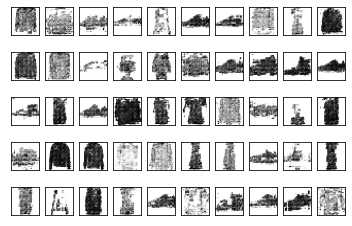

In [66]:

with t.no_grad():
  z = t.randn(50, latent_size).cuda()
  # lab = t.nn.functional.one_hot(t.arange(50).cuda() % 10, num_classes = num_classes).float()

  ims = gen(z).cpu()
  _, axs = plt.subplots(5, 10)
  axs = axs.flatten()
  for im, ax in zip(ims, axs):
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    ax.imshow(im.squeeze(), cmap="gray_r")
    
  
  plt.show()